<h1>1. Initial Imports</h1>

In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
# os.environ['TF_CUDNN_RESET_RND_GEN_STATE'] = '1' 
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async' 
# os.environ['CUDA_VISIBLE_DEVICES'] = '' 
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=4096'

In [2]:
pin_name = "ResNet152-GRU-Flickr30k-FastText-BahdanauAttention-Indo-S1" 
base_dir = "/"
dataset_dir = 'dataset/flickr30k'

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

import fasttext
import heapq
from tqdm import tqdm

#custom imports data_loader on root dir
from data_loader import FlickrDataset, get_data_loader

<h1>3. Init Config Dataset and Dataloader</h1>

In [2]:
# #defining the transform to be applied
# transforms = T.Compose([
#     T.Resize(226),                     
#     T.RandomCrop(224),                 
#     T.ToTensor(),                               
#     T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
# ])

# #testing the dataset class
# dataset =  FlickrDataset(
#     root_dir = dataset_dir+'/images',
#     caption_file = dataset_dir+"/flickr30k-id-train-pin.csv",
#     transform=transforms,
#     freq_threshold=5
# )

In [3]:
# dataset_weights = {
#     "dataset": dataset
# }

# torch.save(dataset, 'weights/dataset-flickr8k-fin.pt')
import torch
dataset = torch.load('weights/dataset-flickr30k-fin.pt')

In [4]:
#vocab_size
vocab_size = len(dataset.vocab)
vocab_size

5747

In [5]:
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True,
    # batch_first=False
)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

<h1>5. Defining the Model Architecture</h1>

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models

In [8]:
class EncoderCNN(nn.Module):
    """Encodes images using a pre-trained ResNet model.

    Args:
        pretrained (bool): If True, use a pre-trained ResNet model.

    Attributes:
        base_model (nn.Module): The pre-trained ResNet model.
        fine_tune_status (bool): Whether the model is fine-tuned.

    """
    def __init__(self):
        super().__init__()
        # resnet = models.resnet50(pretrained=True)
        arch = models.resnet152(weights='IMAGENET1K_V1')
        for param in arch.parameters():
            param.requires_grad_(False)
            
        modules = list(arch.children())[:-2]
        self.arch = nn.Sequential(*modules)
        self.fine_tune_status = False
        
    def forward(self, images):
        features = self.arch(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

    def fine_tune(self, status=False):
        self.fine_tune_status = status
        if not status:
            for param in self.arch.parameters():
                param.requires_grad_(False)
        else:
            for module in list(self.arch.children())[7:]:
                for param in module.parameters():
                    param.requires_grad_(True)

In [9]:
#Bahdanau Attention
class Attention(nn.Module):
    """Implements Bahdanau Attention for focusing on relevant input features.

    Args:
        encoder_dim (int): Dimension of the encoder output features.
        decoder_dim (int): Dimension of the decoder's hidden state.
        attention_dim (int): Dimension of the intermediate attention layer.

    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)

        self.A = nn.Linear(attention_dim,1)


    def forward(self, features, hidden_state):
        """Calculates attention weights and the attention-weighted context vector.

        Args:
            features (torch.Tensor): Encoded image features (batch_size, num_layers, encoder_dim)
            hidden_state (torch.Tensor): Current decoder hidden state (batch_size, decoder_dim)

        Returns:
            tuple:
                - alpha (torch.Tensor): Attention weights (batch_size, num_layers)
                - attention_weights (torch.Tensor): Context vector (batch_size, encoder_dim)
        """
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)

        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)

        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)


        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)

        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)

        return alpha,attention_weights

In [10]:
class DecoderRNN(nn.Module):
    """Recurrent decoder with attention for image captioning.

    Args:
        num_layers (int): Number of stacked GRU layers.
        embed_size (int): Size of the word embedding vectors.
        vocab_size (int): Size of the vocabulary.
        attention_dim (int): Dimension of the attention layer.
        encoder_dim (int): Dimension of the encoder features.
        decoder_dim (int): Dimension of the decoder's hidden state.
        word_vector (torch.Tensor): Pre-trained word embedding vectors.
        drop_prob (float): Dropout probability (default: 0.5).
    """
    def __init__(self, num_layers, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, word_vector, drop_prob=0.5):
        super().__init__()

        # Save model parameters
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        self.num_layers = num_layers

        # Initialize embedding layer with pretrained word vectors
        # self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding = nn.Embedding.from_pretrained(word_vector, freeze=True)

        # Attention mechanism
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        # Initialize linear layer for initializing hidden state
        self.init_h = nn.Linear(encoder_dim, decoder_dim)

        # Define GRU layers
        self.gru_layers = nn.ModuleList([nn.GRUCell(embed_size + encoder_dim if layer == 0 else decoder_dim, decoder_dim) for layer in range(num_layers)])

        # Define output layer
        self.fcn = nn.Linear(decoder_dim, vocab_size)

        # Dropout layer
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        """Performs the forward pass of the decoder.

        Args:
            features (torch.Tensor): Encoded image features (batch_size, num_layers, encoder_dim).
            captions (torch.Tensor): Input captions (batch_size, caption_length).
    
        Returns:
            tuple:
                - preds (torch.Tensor): Predicted word scores (batch_size, caption_length, vocab_size).
                - alphas (torch.Tensor): Attention weights (batch_size, caption_length, num_features).
        """
        embeds = self.embedding(captions)
        h = self.init_hidden_state(features)
        seq_length = len(captions[0]) - 1
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)

        for s in range(seq_length):
            alpha, context = self.attention(features, h[-1])  # Use the last hidden state
            gru_input = torch.cat((embeds[:, s], context), dim=1)

            for layer in range(self.num_layers):
                h[layer] = self.gru_layers[layer](gru_input, h[layer])
                gru_input = h[layer]

            output = self.fcn(self.drop(gru_input))
            preds[:, s] = output
            alphas[:, s] = alpha

        return preds, alphas

    def generate_caption(self, features, beam_width=5, max_len=100, vocab=None):
        """Performs the forward pass of the decoder.

        Args:
            features (torch.Tensor): Encoded image features (batch_size, num_layers, encoder_dim).
            captions (torch.Tensor): Input captions (batch_size, caption_length).
    
        Returns:
            tuple:
                - preds (torch.Tensor): Predicted word scores (batch_size, caption_length, vocab_size).
                - alphas (torch.Tensor): Attention weights (batch_size, caption_length, num_features).
        """
        batch_size = features.size(0)
        alphas = []
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        # Initialize the beam search starting with '<SOS>' token
        h = self.init_hidden_state(features)  # Initialize hidden state
        beams = [([], 0, h, embeds, []) for _ in range(beam_width)]
        all_captions = []

        for _ in range(max_len):
            next_beams = []
            for caption, log_prob, h, prev_embeds, indices in beams:
                # If the last token in the caption is '<EOS>', add it to all_captions
                if len(caption) > 0 and caption[-1] == vocab.stoi['<EOS>']:
                    all_captions.append((caption, log_prob))
                    continue

                # Generate the next token
                alpha, context = self.attention(features, h[-1])
                alphas.append(alpha.cpu().detach().numpy())
                gru_input = torch.cat((prev_embeds[:, 0], context), dim=1)
                h_new = []
                for layer in range(self.num_layers):
                    h_layer = self.gru_layers[layer](gru_input, h[layer])
                    h_new.append(h_layer)
                    gru_input = h_layer
                output = self.fcn(self.drop(gru_input))
                log_probs = F.log_softmax(output, dim=1)

                # Apply beam search
                top_log_probs, top_indices = torch.topk(log_probs, beam_width)
                for i in range(beam_width):
                    next_token = top_indices[0][i].item()
                    next_log_prob = top_log_probs[0][i].item()
                    next_caption = caption + [next_token]
                    next_h = [h_i.clone() for h_i in h_new]  # Clone the hidden states
                    next_embeds = self.embedding(torch.tensor([[next_token]]).to(device))
                    next_beams.append((next_caption, log_prob + next_log_prob, next_h, next_embeds, indices + [next_token]))

            # Select the top beams
            beams = heapq.nlargest(beam_width, next_beams, key=lambda x: x[1])

        # Add remaining beams to all_captions
        all_captions.extend([(caption, log_prob) for caption, log_prob, _, _, _ in beams])

        # Select the beam with the highest probability
        best_caption, _ = max(all_captions, key=lambda x: x[1])

        return [vocab.itos[idx] for idx in best_caption], alphas

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = [self.init_h(mean_encoder_out) for _ in range(self.num_layers)]
        return h

In [11]:
class EncoderDecoder(nn.Module):
    """Image captioning model combining CNN encoder and RNN decoder with attention.

    Args:
       num_layers (int): Number of layers in the decoder's RNN.
       embed_size (int): Size of word embedding vectors.
       vocab_size (int): Size of the vocabulary.
       attention_dim (int): Dimension of the attention layer.
       encoder_dim (int): Dimension of the encoder's output features.
       decoder_dim (int): Dimension of the decoder's hidden state.
       word_vector (torch.Tensor): Pre-trained word embedding vectors.
       drop_prob (float): Dropout probability (default: 0.3).
    """ 
    def __init__(self, num_layers, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, word_vector, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            num_layers=num_layers,
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
            word_vector=word_vector
        )
        
    def forward(self, images, captions):
        """Performs image captioning.

        Args:
            images (torch.Tensor): Input images (batch_size, num_channels, height, width).
            captions (torch.Tensor): Caption word indices (batch_size, caption_length).

        Returns:
            torch.Tensor: Predicted vocabulary scores for each word in the caption.
        """
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

<h1>5. Set Word Embedding Use FastText</h1>

In [30]:
# import fasttext.util
# fasttext.FastText.eprint = lambda x: None
# ft = fasttext.load_model('fasttext/cc.id.300.bin')

# embedding_matrix = torch.FloatTensor(ft.get_input_matrix())
# # ft.get_nearest_neighbors('malam')

# # Get the dimension of the FastText word vectors
# embedding_dim = ft.get_dimension()

# # Initialize the embedding matrix with zeros
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# # Populate the embedding matrix with FastText word vectors
# for key, word in enumerate(dataset.vocab.itos.items()):
#     if word[1] in ["siluet", "seorang", "pria"]:
#         print(word[1], key)
#     if word[1] in ft.words:
#         # print(key, word[1])
#         # print(ft.get_word_vector(word[1]))
#         # print(ft.get_nearest_neighbors('anjing'))
#         embedding_matrix[key] = ft.get_word_vector(word[1])

# del ft

# # # Convert the embedding matrix to a PyTorch tensor
# embedding_matrix = torch.Tensor(embedding_matrix)

seorang 5
pria 6
siluet 1271


In [13]:
# embed_weights = {
#     "embedding_matrix": embedding_matrix
# }

# torch.save(embed_weights, 'weights/fasttext-flickr8k-fin.pt')
embed_weights = torch.load('weights/fasttext-flickr30k-fin.pt')
embedding_matrix = embed_weights['embedding_matrix']

In [31]:
len(embedding_matrix[1])

300

<h1>7. Settings Hyperparam And Init The Model</h1>

In [17]:
# Init model
model = None
is_new_model = False
embed_size=len(embedding_matrix[1])
vocab_size = len(dataset.vocab)
attention_dim=128
encoder_dim=2048
decoder_dim=512
num_layers=3
learning_rate = 5e-4
fine_tune=True

In [18]:
def load_model(filepath):
    # Load the model state dictionary
    model_state = torch.load(filepath)
    
    loaded_model = EncoderDecoder(
        num_layers = model_state['num_layers'],
        embed_size = model_state['embed_size'],
        vocab_size = 2860,
        attention_dim = model_state['attention_dim'],
        encoder_dim = model_state['encoder_dim'],
        decoder_dim = model_state['decoder_dim'],
        word_vector = model_state['word_vector']
    ).to(device)
    
    # # Load the model state
    loaded_model.load_state_dict(model_state['state_dict'])
    
    return loaded_model

In [19]:
model = load_model('model/best-' + pin_name + '.pth')
if model:
    print(pin_name+' Model Has Loaded Succesfully !!!')
else:
    print(pin_name+' Model Has Created Succesfully !!!')

ResNet152-GRU-Flickr30k-FastText-BahdanauAttention-Indo-S1 Model Has Loaded Succesfully !!!


In [61]:
model

EncoderDecoder(
  (encoder): EncoderCNN(
    (arch): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
   

In [49]:
with torch.no_grad():
    outputs = model(sample_images, sample_captions)
    dot = make_dot(outputs, params=dict(model.named_parameters()))

<h1>8. Bleu Score Calculation Function</h1>

In [23]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from nltk.translate import meteor_score

In [24]:
def bleu_score(img_name, candidate_caption, reference_captions):    
    # Tokenize the reference and candidate captions
    reference_tokens = [word_tokenize(ref) for ref in reference_captions]
    candidate_tokens = word_tokenize(candidate_caption)
    
    # Calculate BLEU score for the candidate caption
    # Use smoothing function to handle cases with zero counts of n-gram overlaps
    smoother = SmoothingFunction()
    
    bleu_scores = []
    for n in range(1, 5):  # Calculate BLEU scores up to 4-grams
        bleu = sentence_bleu(reference_tokens, candidate_tokens, weights=[1.0/n] * n, smoothing_function=smoother.method1)
        bleu_scores.append(round(bleu, 4))
    
    return bleu_scores

In [25]:
def check_bleu(img_name, caption, df):
    reference_captions = df.loc[df['image'] == img_name]['caption'].tolist()
    reference_captions = [caption.lower().replace(".", "").strip() for caption in reference_captions]
    
    # reference_captions = [[caption] for caption in selected_captions]
    caption = caption.replace("<SOS>", "").replace("<EOS>", "").strip()
    # print("Caption: ", caption)
    # print("Ref Caption: ", reference_captions)
    bleu = bleu_score(img_name, caption, reference_captions)

    return bleu

In [26]:
def meteor_metric(img_name, caption, df):
    
    reference_captions = df.loc[df['image'] == img_name]['caption'].tolist()
    reference_captions = [caption.lower().replace(".", "").strip() for caption in reference_captions]

    caption = caption.replace("<SOS>", "").replace("<EOS>", "").strip()

    # print("Caption: ", caption)
    # print("Ref Caption: ", reference_captions)

    # Tokenisasi kalimat
    reference_tokens = [nltk.word_tokenize(ref.lower()) for ref in reference_captions]
    translation_tokens = nltk.word_tokenize(caption.lower())

    # Hitung METEOR score
    score = meteor_score.meteor_score(reference_tokens, translation_tokens)

    return score

<h1>12. Visualizing the attentions</h1>
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [27]:
#generate caption
def get_caps_from(features_tensors, img_name, show=False):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        if show:
            show_image(features_tensors[0], img_name, title=caption)
    
    return caps, alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    num_rows = len(result) // 2 + len(result) % 2  # Add 1 row if len(result) is odd
    num_cols = 5
        
    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(num_rows, num_cols, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

In [28]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, img_name, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.cpu().numpy().transpose((1, 2, 0))
        
    plt.imshow(img)
    if title is not None:
        plt.title(title)
        # plt.title('seorang pria sedang memasak di atas panggangan di luar ruangan . <EOS>')
    
    # Turn off tick labels
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig('sample/'+img_name, bbox_inches='tight')
    plt.pause(0.001)  # pause a bit so that plots are updated

<h1>13. Test Data</h1>

In [37]:
import pandas as pd
df_test = pd.read_csv(dataset_dir+'/flickr30k-id-test-pin.csv')
df_test.head()

,image,caption
0,1009434119.jpg,Seekor anjing terrier Boston sedang berlari di...
1,1009434119.jpg,Seekor anjing hitam dan putih sedang berlari d...
2,1009434119.jpg,Seekor anjing berlari di atas rumput hijau di ...
3,1009434119.jpg,Seekor anjing Boston Terrier sedang berlari di...
4,1009434119.jpg,Seekor anjing hitam dan putih berlari di taman...


In [38]:
test_list = df_test['image'].unique().tolist()

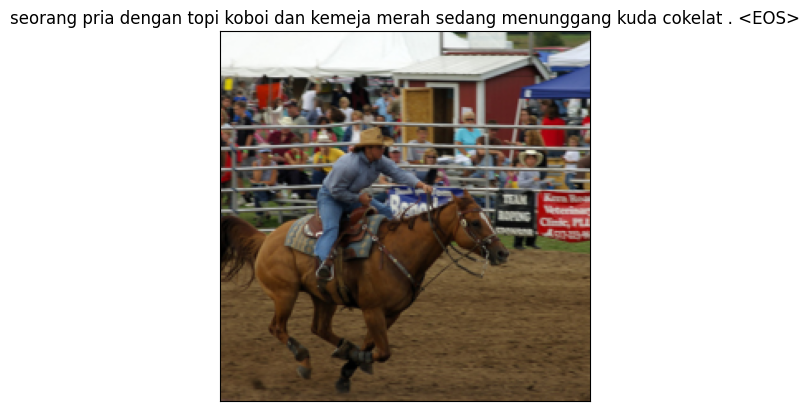

In [45]:
from PIL import Image

random_row = df_test.sample(n=1)
img_file = random_row['image'].iloc[0]
# img_file = '3126867551.jpg'
select_img = dataset_dir+'/images/'+img_file

# # Load the image
# select_img = 'Segmentation/images/cropped/crop-33.png'
img = Image.open(select_img).convert('RGB')

# Define transformations to preprocess the image
tr = T.Compose([
    T.Resize(224),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

# Preprocess the image
img_tensor = tr(img)

# Add batch dimension as your model expects it
img_tensor = img_tensor.unsqueeze(0)

# Get captions and attention weights
caps, alphas = get_caps_from(img_tensor, 'sample', True)

# # Visualize attention weights
# plot_attention(img_tensor.squeeze(0), caps, alphas)

In [31]:
print("Image Name : ", img_file)
bleus = check_bleu(img_file, ' '.join(caps), df_test)
print("Bleu Scores: ", bleus)
meteor_ = meteor_metric(img_file, ' '.join(caps), df_test)
print("Meteor Score: ", round(meteor_, 4))

Image Name :  2784625888_71a421e171.jpg
Bleu Scores:  [0.8571, 0.5345, 0.3852, 0.1944]
Meteor Score:  0.5357
